<a href="https://www.kaggle.com/rsizem2/tps-02-22-separating-high-low-resolution-data?scriptVersionId=88748941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Separating High and Low Resolution Data

The original paper found that certain algorithms performed better on data generated from higher/low resolution samples or that had fewer/more errors. In this notebook, we subset the data based off of the number of reads from which it was generated and train models on various combinations of these subsets to see if we can get improved results. 

## Overview

From the description in the original paper, each training example consists of length 10 samples of the full bacterial DNA gotten by the following process:

$$\cdots \text{ATCG}\textbf{CTGGATAGCA}\text{TACG} \cdots \xrightarrow{sample} \text{CTGGATAGCA} \xrightarrow{bin} A_3T_2G_3C_2$$

Each training example consists of either 1 million, 100k, 1k or 100 length 10 reads, which are then turned into a probability distribution and altered by subtracting off the bias distribution (expected distribution of randomly generated DNA sequences). We refer to the subset of data generated from 1 million or 100k reads as the **high resolution data** and the subset generated by 1000 or 100 reads as the **low resolution data**. With some work, we can retrieve (a constant multiple of) the original samples from the provided training data and we distinguish each subset by the GCD of the samples.

We can predict almost perfectly on the high resolution data and with varying results on the low resolution data. So we will attempt to train separate models on combinations of these subsets to see if we can get improved CV or public leaderboard scores. 

**Credits:** Some of the helper functions I used to process the data were borrowed from this [EDA notebook](https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense) by AmbrosM, so please check it out and give it an upvote.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 99
NUM_FOLDS = 10

In [2]:
# Generic Imports
import numpy as np
import pandas as pd
import pyarrow
import time
import gc

# Label Encoding
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Preparation

We remove duplicate samples from the training set by consolidating them into one row and adding a `sample_weight` column. For cross-validation we use a stratified approach using the labels and resolution/GCD.

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

# Function for downcasting float/int datatypes
def reduce_memory_usage(path):
    df = pd.read_csv(path);
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
    return df

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

def get_target_bins():
    temp = train[['target','target']].copy()
    temp.columns = ['row_id','target']
    temp['row_id'] = gcd_of_all(get_histograms(train[features]))
    return temp['row_id'].astype(str) + temp['target'].astype(str)

def remove_duplicates(input_df):
    # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = input_df[features + ['target']].value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df[features + ['target']].columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

In [4]:
%%time

# Load and Reduce memory
try:
    train = pd.read_feather('train.feather')
    test = pd.read_feather('test.feather')
except:
    train = reduce_memory_usage('../input/tabular-playground-series-feb-2022/train.csv')
    train.to_feather('train.feather')
    test = reduce_memory_usage('../input/tabular-playground-series-feb-2022/test.csv')
    test.to_feather('test.feather')
    
# Label encoding
encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])

# Features and Target Bins
features = [x for x in train.columns if x not in ['row_id','target']]
train = remove_duplicates(train)
train['gcd'] = gcd_of_all(get_histograms(train[features]))
target_bins = get_target_bins()

# Stratified K-fold
SKF = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)

submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: user 50.3 s, sys: 10.9 s, total: 1min 1s
Wall time: 1min 13s


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from scipy.stats import mode
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Scoring/Training Baseline Function
def score_model(sklearn_model):
    
    # Store the holdout predictions
    oof_preds = np.zeros((len(train),))
    test_proba = np.zeros((len(test),len(train['target'].unique())))
    test_preds = list()
    scores = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    for fold, (train_idx, valid_idx) in enumerate(SKF.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        X_test = test[features]
        
        # Create model
        model = clone(sklearn_model); start = time.time()
        model.fit(X_train, y_train, sample_weight = train['sample_weight'].iloc[train_idx])
        
        # Predictions
        valid_preds = np.argmax(model.predict_proba(X_valid), axis = 1)
        test_prob = model.predict_proba(X_test)
        test_proba += test_prob / NUM_FOLDS
        test_preds.append(np.argmax(test_prob, axis = 1))
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = train['sample_weight'].iloc[valid_idx])
        oof_preds[valid_idx] = valid_preds
        
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(time.time()-start,2)}s.')
    
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    return oof_preds, np.argmax(test_proba, axis = 1), mode(test_preds).mode[0]

# Confusion Matrix Plotting
def plot_confusion_matrix(true_values, pred_values, gcds, sample_weight = None, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,10))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            if sample_weight is not None:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
            else:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
            ax[row,col].set_title(f'GCD = {gcd[row][col]}, Accuracy: {round(acc, 5)}')
    plt.show()

# Baseline

Our baseline is an `ExtraTreesClassifier` trained using all the data regardless of the resolution.

In [6]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

# Default Parameters
EXT_PARAMS = dict(n_estimators = 300, random_state = RANDOM_SEED, n_jobs = -1)

CPU times: user 54.8 ms, sys: 20.9 ms, total: 75.7 ms
Wall time: 205 ms



Fold 0: 0.95723 accuracy in 38.8s.
Fold 1: 0.95318 accuracy in 38.68s.
Fold 2: 0.9557 accuracy in 38.48s.
Fold 3: 0.9543 accuracy in 38.77s.
Fold 4: 0.95702 accuracy in 38.78s.
Fold 5: 0.95194 accuracy in 38.98s.
Fold 6: 0.95854 accuracy in 41.3s.
Fold 7: 0.95965 accuracy in 38.52s.
Fold 8: 0.95615 accuracy in 38.57s.
Fold 9: 0.95431 accuracy in 39.52s.

Average Accuracy: 0.9558


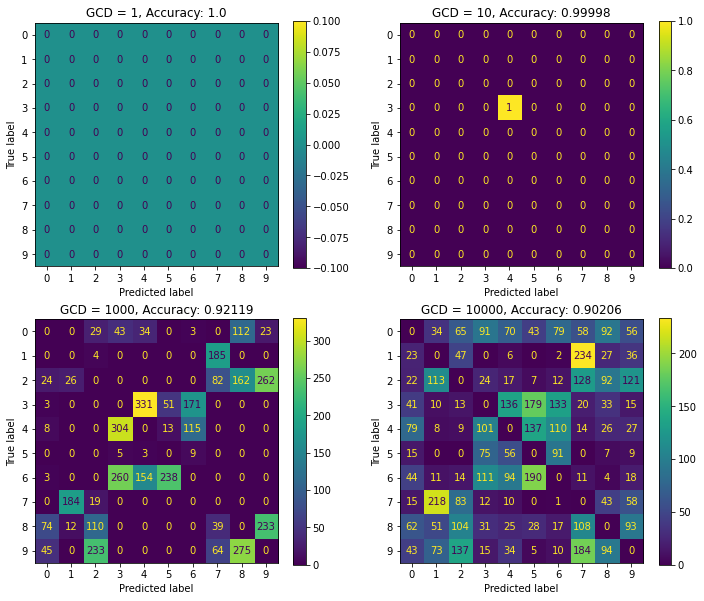

In [7]:
# ExtraTrees Baseline
oof_preds, test_soft, test_hard = score_model(ExtraTreesClassifier(**EXT_PARAMS))

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('extratrees_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('extratrees_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# Custom Estimators

We build an custom scikit-learn compatible estimator class which splits the input data based on the GCD of the histograms and trains a separate model on each subset. 

## 1. Four Separate Models

In this instance, we train a separate `ExtraTreesClassifier` on each subset of the data. That is, on the samples corresponding to 1M, 100k, 1k, and 100 reads, respectively. Unhide the following code block to see the details:

In [8]:
from sklearn.base import BaseEstimator, clone

class FourResolutions(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 1,000,000 BOC Reads
        self.model2 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 100,000 BOC Reads
        self.model3 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 1,000 BOC Reads
        self.model4 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 100 BOC Reads
            
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1)
        self.gcd2 = (gcd == 10)
        self.gcd3 = (gcd == 1000)
        self.gcd4 = (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight = None):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        if sample_weight is not None:
            self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
            self.model3.fit(X[self.gcd3], y[self.gcd3], sample_weight[self.gcd3])
            self.model4.fit(X[self.gcd4], y[self.gcd4], sample_weight[self.gcd4])
        else:
            self.model1.fit(X[self.gcd1], y[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2])
            self.model3.fit(X[self.gcd3], y[self.gcd3])
            self.model4.fit(X[self.gcd4], y[self.gcd4])
            
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict_proba(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict_proba(X[self.gcd4])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict(X[self.gcd4])
        return temp.astype(int)


Fold 0: 0.95588 accuracy in 33.22s.
Fold 1: 0.95479 accuracy in 32.28s.
Fold 2: 0.95765 accuracy in 33.42s.
Fold 3: 0.95484 accuracy in 32.81s.
Fold 4: 0.95558 accuracy in 32.44s.
Fold 5: 0.95369 accuracy in 32.13s.
Fold 6: 0.95839 accuracy in 32.72s.
Fold 7: 0.9594 accuracy in 33.25s.
Fold 8: 0.9558 accuracy in 32.37s.
Fold 9: 0.9529 accuracy in 32.66s.

Average Accuracy: 0.95589


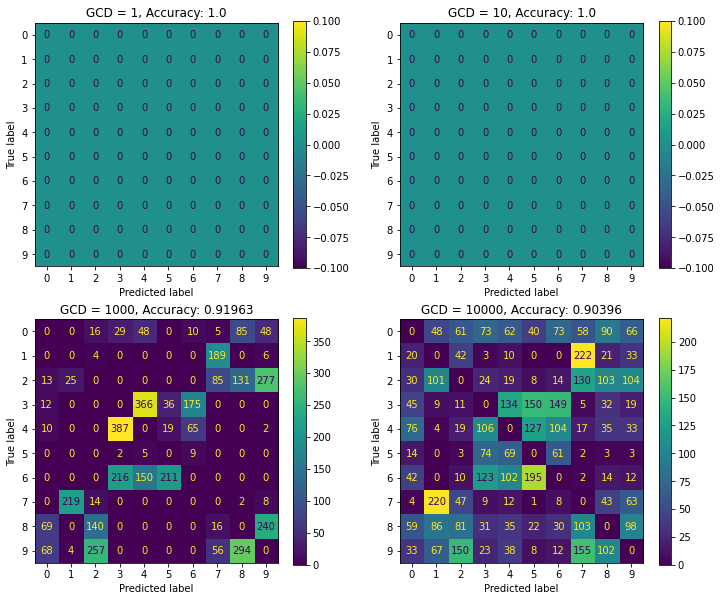

In [9]:
oof_preds, test_soft, test_hard = score_model(FourResolutions())

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('fourmodels_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('fourmodels_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 2. Split High/Low Resolution

In this instance we train two separate ExtraTrees models, one using the high resolution data (1 million and 100k reads) and one using the low resolution data (1000 and 100 reads).

In [10]:
class HighLowSplit(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 10^6 and 10^5 BOC Reads
        self.model2 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 10^2 and 10^3 BOC Reads
            
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1) | (gcd == 10)
        self.gcd2 = (gcd == 1000) | (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight = None):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        if sample_weight is not None:
            self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
        else:
            self.model1.fit(X[self.gcd1], y[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2])
            
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        return temp.astype(int)


Fold 0: 0.95588 accuracy in 37.41s.
Fold 1: 0.95373 accuracy in 36.61s.
Fold 2: 0.9584 accuracy in 37.95s.
Fold 3: 0.95628 accuracy in 38.67s.
Fold 4: 0.95905 accuracy in 41.01s.
Fold 5: 0.95629 accuracy in 38.88s.
Fold 6: 0.95542 accuracy in 38.67s.
Fold 7: 0.96046 accuracy in 40.63s.
Fold 8: 0.9549 accuracy in 38.32s.
Fold 9: 0.9528 accuracy in 38.71s.

Average Accuracy: 0.95632


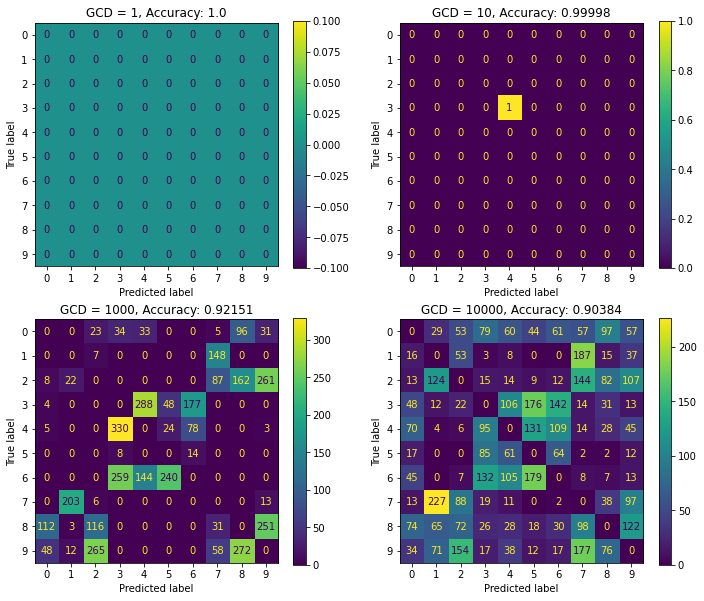

In [11]:
oof_preds, test_soft, test_hard = score_model(HighLowSplit())

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('split_highlow_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('split_highlow_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## 3. Isolate Lowest Resolution

In this instance, we again train only two moodels, one using all but the lowest resolution data and the other only on the lowest resolution data (100 reads).

In [12]:
class IsolateLowRes(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 10^6, 10^5 10^3 BOC Reads
        self.model2 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 10^2 BOC Reads
            
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1) | (gcd == 10) | (gcd == 1000) 
        self.gcd2 = (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight = None):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        if sample_weight is not None:
            self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
        else:
            self.model1.fit(X[self.gcd1], y[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2])
            
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        return temp.astype(int)


Fold 0: 0.95434 accuracy in 37.84s.
Fold 1: 0.95333 accuracy in 37.57s.
Fold 2: 0.9581 accuracy in 37.35s.
Fold 3: 0.95618 accuracy in 37.5s.
Fold 4: 0.95831 accuracy in 38.35s.
Fold 5: 0.95849 accuracy in 36.89s.
Fold 6: 0.95879 accuracy in 37.39s.
Fold 7: 0.96011 accuracy in 37.38s.
Fold 8: 0.9566 accuracy in 37.53s.
Fold 9: 0.95541 accuracy in 37.51s.

Average Accuracy: 0.95697


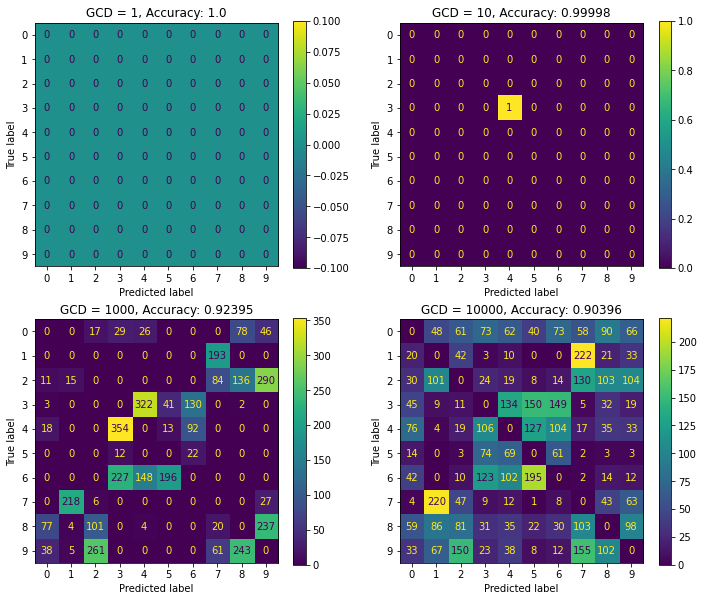

In [13]:
oof_preds, test_soft, test_hard = score_model(IsolateLowRes())

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('isolate_lowest_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('isolate_lowest_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])